In [1]:
##Setting up the python environment-loading modules commonly used.
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##Setting up Google sdk environment
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/marcelkc/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-nigam-starr' #som-nero-phi-rit
%load_ext google.cloud.bigquery

In [3]:
##Setting up BQ API
from google.cloud import bigquery
client=bigquery.Client()

/share/sw/open/anaconda/3/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
##Read in covid tests
query="""SELECT measurement_DATE, measurement_DATETIME, measurement_time, value_source_value, year_of_birth, month_of_birth, day_of_birth, 
gender_concept_id, visit_concept_id, race_concept_id, ethnicity_concept_id,
FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.measurement`
INNER JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.person` USING (person_id)
INNER JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.visit_occurrence` USING (visit_occurrence_id)
WHERE measurement_concept_id = 706170"""
query_job =client.query(query)
test=query_job.to_dataframe()
test.to_csv("covid_tests", sep=' ')
test.head()


,measurement_DATE,measurement_DATETIME,measurement_time,value_source_value,year_of_birth,month_of_birth,day_of_birth,gender_concept_id,visit_concept_id,race_concept_id,ethnicity_concept_id
0,2020-04-21,2020-04-21 11:21:00,None,Not Detected,1987,10,29,8532,0,0,0
1,2020-04-21,2020-04-21 19:11:00,None,None,1987,10,29,8532,0,0,0
2,2020-03-07,2020-03-07 01:10:00,None,Not Detected,1999,5,3,8507,0,0,38003563
3,2020-03-07,2020-03-07 00:32:00,None,None,1999,5,3,8507,0,0,38003563
4,2020-03-02,2020-03-02 11:39:00,None,Not Detected,1979,3,12,8507,0,8527,38003564


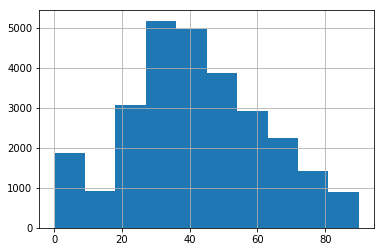

In [5]:
##work with data in panda to make prettier table

## test results
# test['value_source_value'].value_counts()
positive_value_source_value = lambda x: x in ['Detected', 'DETECTED', 'Pos']
pos_test_bool_col = test['value_source_value'].apply(positive_value_source_value).rename('positive')

## age results
import pandas as pd
meas_dt_col = test['measurement_DATE'].apply(lambda x : pd.to_datetime(x))
pat_bd_dt_col = test[['year_of_birth', 'month_of_birth', 'day_of_birth']].apply(lambda x: pd.to_datetime('-'.join([str(i) for i in x])), axis=1)

pat_age_col = meas_dt_col - pat_bd_dt_col
pat_age_col = pat_age_col.apply(lambda x: x.days/365.25).rename('age')

pat_age_col.hist()

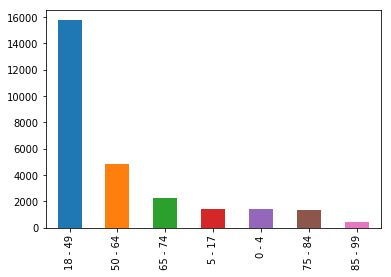

In [6]:
import numpy as np
bins = [0, 5, 18, 50, 65, 75, 85, 100]
labels = ["{0} - {1}".format(i, j-1) for i, j in zip(bins[:-1], bins[1:])]
age_cat_col = pd.cut(pat_age_col, bins, labels=labels)
age_cat_col.value_counts().plot(kind='bar')

In [7]:
## include visit_concept_id, pat_age_col, pos_test_bool_col
df = pd.concat([pos_test_bool_col, age_cat_col, test['visit_concept_id']], axis=1)
df['tested']=1
df.head()


pd.pivot_table(df, values=['tested', 'positive'], index=['visit_concept_id'],
                    columns=['age'], aggfunc=np.sum)

positive                                                 \
age                 0 - 4 5 - 17 18 - 49 50 - 64 65 - 74 75 - 84 85 - 99   
visit_concept_id                                                           
0                     8.0   27.0   483.0   202.0   105.0    59.0    28.0   
9201                  1.0    5.0    82.0    37.0    18.0    23.0     4.0   
9202                  1.0    4.0    39.0    34.0    10.0     4.0     2.0   
9203                  NaN    NaN     0.0     0.0     0.0     NaN     NaN   

                 tested                                                   
age               0 - 4  5 - 17  18 - 49 50 - 64 65 - 74 75 - 84 85 - 99  
visit_concept_id                                                          
0                 989.0  1050.0  11939.0  3088.0  1574.0   918.0   352.0  
9201              358.0   279.0   2212.0   982.0   432.0   299.0    70.0  
9202               30.0    72.0   1591.0   744.0   274.0    94.0    15.0  
9203                NaN     NaN      2.0     2.0     2.0     NaN     NaN

8532    17216
8507    10108
0          44
Name: gender_concept_id, dtype: int64


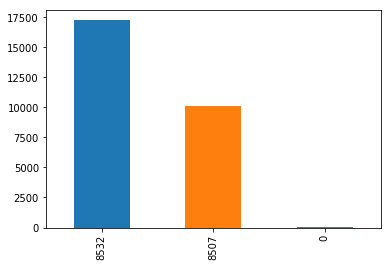

In [8]:
col_nm = 'gender_concept_id'
print(test[col_nm].value_counts())
plt.figure()
test[col_nm].value_counts().plot(kind='bar')

In [9]:
## include visit_concept_id, pat_age_col, pos_test_bool_col
df = pd.concat([pos_test_bool_col, test[col_nm], test['visit_concept_id']], axis=1)
df['tested']=1
pd.pivot_table(df, values=['tested', 'positive'], index=['visit_concept_id'],
                    columns=[col_nm], aggfunc=np.sum)

positive               tested                 
gender_concept_id     0      8507   8532   0       8507     8532
visit_concept_id                                                
0                      0.0  405.0  507.0   40.0  6758.0  13112.0
9201                   0.0   94.0   76.0    2.0  2305.0   2325.0
9202                   0.0   42.0   52.0    2.0  1041.0   1777.0
9203                   NaN    0.0    0.0    NaN     4.0      2.0

0       13185
8527     9587
8515     3498
8516      755
8557      291
8657       52
Name: race_concept_id, dtype: int64


positive                               tested                 \
race_concept_id      0     8515 8516   8527 8557 8657     0       8515   8516   
visit_concept_id                                                                
0                   664.0  59.0  8.0  175.0  3.0  3.0  11142.0  2189.0  471.0   
9201                 53.0  32.0  2.0   76.0  7.0  0.0   1316.0   761.0  195.0   
9202                 22.0  18.0  2.0   50.0  2.0  0.0    725.0   548.0   89.0   
9203                  0.0   NaN  NaN    0.0  NaN  NaN      2.0     NaN    NaN   

                                       
race_concept_id     8527   8557  8657  
visit_concept_id                       
0                 5930.0  149.0  29.0  
9201              2239.0  112.0   9.0  
9202              1414.0   30.0  14.0  
9203                 4.0    NaN   NaN

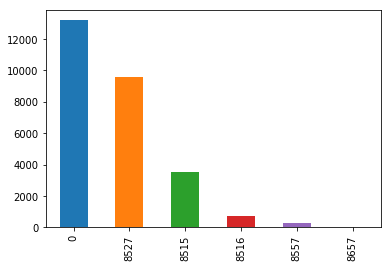

In [10]:
col_nm = 'race_concept_id'
print(test[col_nm].value_counts())
plt.figure()
test[col_nm].value_counts().plot(kind='bar')
## include visit_concept_id, pat_age_col, pos_test_bool_col
df = pd.concat([pos_test_bool_col, test[col_nm], test['visit_concept_id']], axis=1)
df['tested']=1
pd.pivot_table(df, values=['tested', 'positive'], index=['visit_concept_id'],
                    columns=[col_nm], aggfunc=np.sum)

38003564    14610
0            9428
38003563     3330
Name: ethnicity_concept_id, dtype: int64


positive                     tested                  
ethnicity_concept_id 0        38003563 38003564 0        38003563 38003564
visit_concept_id                                                          
0                       564.0    116.0    232.0   8972.0   2008.0   8930.0
9201                      1.0     49.0    120.0     62.0   1009.0   3561.0
9202                      9.0     12.0     73.0    392.0    313.0   2115.0
9203                      0.0      NaN      0.0      2.0      NaN      4.0

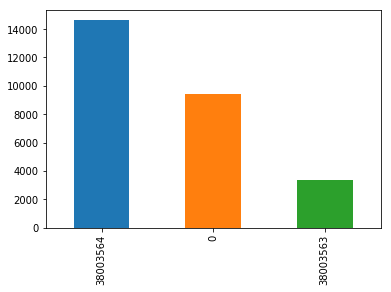

In [11]:
col_nm = 'ethnicity_concept_id'
print(test[col_nm].value_counts())
plt.figure()
test[col_nm].value_counts().plot(kind='bar')
## include visit_concept_id, pat_age_col, pos_test_bool_col
df = pd.concat([pos_test_bool_col, test[col_nm], test['visit_concept_id']], axis=1)
df['tested']=1
pd.pivot_table(df, values=['tested', 'positive'], index=['visit_concept_id'],
                    columns=[col_nm], aggfunc=np.sum)

In [16]:
## include visit_concept_id, pat_age_col, pos_test_bool_col
df = pd.concat([pos_test_bool_col, age_cat_col, test['visit_concept_id'], test['race_concept_id']], axis=1)
df['tested']=1
df.head()


pd.pivot_table(df, values=['tested', 'positive'], index=['race_concept_id','age'],
                    columns=['visit_concept_id'], aggfunc=np.sum)

positive                   tested                   
visit_concept_id            0     9201  9202 9203    0      9201   9202 9203
race_concept_id age                                                         
0               0 - 4        6.0   0.0   0.0  NaN   640.0  184.0   10.0  NaN
                5 - 17      20.0   3.0   0.0  NaN   610.0  102.0   24.0  NaN
                18 - 49    350.0  26.0  12.0  0.0  6321.0  664.0  458.0  2.0
                50 - 64    146.0  12.0   7.0  NaN  1759.0  222.0  157.0  NaN
                65 - 74     78.0   4.0   1.0  NaN   948.0   89.0   50.0  NaN
                75 - 84     41.0   8.0   1.0  NaN   606.0   49.0   18.0  NaN
                85 - 99     23.0   0.0   1.0  NaN   258.0    6.0    8.0  NaN
8515            0 - 4        0.0   0.0   0.0  NaN    99.0   48.0    2.0  NaN
                5 - 17       2.0   0.0   1.0  NaN   101.0   36.0   14.0  NaN
                18 - 49     41.0  11.0  11.0  NaN  1563.0  429.0  378.0  NaN
                50 - 64     12.0  11.0   6.0  NaN   242.0  141.0  122.0  NaN
                65 - 74      4.0   5.0   0.0  NaN   107.0   51.0   20.0  NaN
                75 - 84      0.0   5.0   0.0  NaN    62.0   46.0   10.0  NaN
                85 - 99      0.0   0.0   0.0  NaN    15.0   10.0    2.0  NaN
8516            0 - 4        0.0   0.0   0.0  NaN    28.0   10.0    2.0  NaN
                5 - 17       0.0   0.0   0.0  NaN    10.0    2.0    6.0  NaN
                18 - 49      4.0   1.0   1.0  NaN   297.0   80.0   49.0  NaN
                50 - 64      1.0   1.0   0.0  NaN    79.0   60.0   18.0  NaN
                65 - 74      1.0   0.0   1.0  NaN    41.0   35.0   12.0  NaN
                75 - 84      2.0   0.0   0.0  NaN     8.0    8.0    2.0  NaN
                85 - 99      0.0   NaN   NaN  NaN     8.0    NaN    NaN  NaN
8527            0 - 4        2.0   1.0   1.0  NaN   216.0  112.0   16.0  NaN
                5 - 17       4.0   1.0   3.0  NaN   315.0  133.0   24.0  NaN
                18 - 49     87.0  42.0  15.0  NaN  3641.0  984.0  678.0  NaN
                50 - 64     41.0  11.0  20.0  0.0   986.0  523.0  439.0  2.0
                65 - 74     22.0   8.0   7.0  0.0   467.0  243.0  188.0  2.0
                75 - 84     14.0   9.0   3.0  NaN   234.0  190.0   64.0  NaN
                85 - 99      5.0   4.0   1.0  NaN    71.0   54.0    5.0  NaN
8557            0 - 4        0.0   0.0   NaN  NaN     4.0    3.0    NaN  NaN
                5 - 17       1.0   1.0   0.0  NaN    14.0    6.0    4.0  NaN
                18 - 49      1.0   2.0   0.0  NaN   102.0   49.0   20.0  NaN
                50 - 64      1.0   2.0   1.0  NaN    20.0   34.0    4.0  NaN
                65 - 74      0.0   1.0   1.0  NaN     5.0   14.0    2.0  NaN
                75 - 84      0.0   1.0   NaN  NaN     4.0    6.0    NaN  NaN
8657            0 - 4        0.0   0.0   NaN  NaN     2.0    1.0    NaN  NaN
                18 - 49      0.0   0.0   0.0  NaN    15.0    6.0    8.0  NaN
                50 - 64      1.0   0.0   0.0  NaN     2.0    2.0    4.0  NaN
                65 - 74      0.0   NaN   0.0  NaN     6.0    NaN    2.0  NaN
                75 - 84      2.0   NaN   NaN  NaN     4.0    NaN    NaN  NaN

In [12]:
#, ,
#
# for ind_visit, grp_visit in df.groupby('visit_concept_id'):
#     for ind_age, grp_age in grp_visit.groupby('age'):
#         grp_age